<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/07_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 一般線形モデル (GLM; generalized linear model)
* 今回はロジスティック回帰を採り上げる。
 * https://docs.pymc.io/notebooks/GLM-logistic.html


## 7.0 一般線形モデルとは
### 7.0.1 線形回帰
 * 線形回帰は、以下のように定式化できる。
$$ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots \beta_d X_d + \epsilon $$
 * $\beta_0, \beta_1, \ldots, \beta_d$が推定すべき係数。
 * $\beta = (\beta_0, \beta_1, \ldots, \beta_d)$、$X = (1, X_1, \ldots, X_d)$とおくと、上式は以下のように書ける。
$$ Y = \beta^\top X + \epsilon $$
* 最小二乗法では、誤差項$\epsilon$が正規分布に従うと仮定し、最尤推定で推定する。


### 7.0.2 線形モデルのgeneralization
* 線形回帰では、正規分布の平均$\mu$が$\beta^\top X$に等しい、と置いている。
 * つまり、$\mu = E[Y | X] = \beta^\top X$と置いている。
* 正規分布以外の分布でも、その分布の平均を$\beta^\top X$の関数で表すことで、正規分布ではモデリングしにくいデータのモデリングに線形モデルを使う可能性が広がる。

### 7.0.3 ロジスティック回帰
* ロジスティック回帰では、正規分布ではなく、ベルヌーイ分布を観測データのモデリングに用いる。
* ベルヌーイ分布の平均$\mu$は、outcomeが$1$となる確率である。
* $\beta^\top X$を$[0,1]$の区間の値に変換するために、シグモイド関数$\mu(s) = \frac{1}{1 + e^{- s}}$を使う。
* ということは、各データ点$\textbf{x}_i = (x_{i,1}, \ldots, x_{i,d})$に対応する、outcomeが$1$となる確率を$p_i = \frac{1}{1 + e^{- \beta^\top \textbf{x}_i}}$として・・・
* 0か1かの正解ラベルを$t_i$と書くと、$\sum_i \{ t_i \log p_i + (1 - t_i) \log (1 - p_i) \}$の最小化によって、最尤推定を行うことができる。
 * ロジスティック回帰の場合のシグモイド関数のような関数を、GLMにおける平均関数(mean function)と呼ぶ。
 * mean functionの逆関数を、リンク関数(link function)と呼ぶ。

### 7.0.4 ポアソン回帰
* ポアソン回帰では、正規分布ではなく、ポアソン分布を観測データのモデリングに用いる。
* ポアソン分布の平均$\mu$は、ポアソン分布の唯一のパラメータそのものである。このパラメータが取る値の範囲は$(0,\infty)$である。
* $\beta^\top X$を$[0,1]$の区間の値に変換するために、指数関数を使う。
* ということは、各データ点$\textbf{x}_i = (x_{i,1}, \ldots, x_{i,d})$に対応するポアソン分布のパラメータを$\lambda_i = e^{\beta^\top \textbf{x}_i}$として・・・
* 正解の回数を$c_i$と書くと、$\sum_i \{ c_i \log \lambda_i - \lambda_i \}$の最大化によって、最尤推定を行うことができる。
 * ポアソン回帰の場合の平均関数は、指数関数。
 * ということは、リンク関数は、対数関数。

### 7.0.5 一般線形モデルのベイズ化
* 一般線形モデルのベイズ化は、線形回帰と同様、係数と切片に事前分布を導入することで行われる。
* PyMC3では、リンク関数を指定する点を除いて、コードの上では大差ない。
 * もちろん、結果の解釈方法は、全く異なる。



---



In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 1234
rng = np.random.default_rng(SEED)
# https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f

## 7.1 データ

* UCI機械学習リポジトリにあるAdult Data Set
 * http://archive.ics.uci.edu/ml/datasets/Adult
* 個人が年間5万ドルを稼ぐかどうかを予測する。

In [ ]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
           "age",
          "workclass",
          "fnlwgt",
          "education-categorical",
          "educ",
          "marital-status",
          "occupation",
          "relationship",
          "race",
          "sex",
          "captial-gain",
          "capital-loss",
          "hours",
          "native-country",
          "income",
    ],
)

In [ ]:
raw_data.head()

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


* fnlwgt (final weight) は後から何らかのプログラムによって計算されて追加されたものらしい。

In [ ]:
raw_data.describe()

,age,fnlwgt,educ,captial-gain,capital-loss,hours
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    32561 non-null  int64 
 1   workclass              32561 non-null  object
 2   fnlwgt                 32561 non-null  int64 
 3   education-categorical  32561 non-null  object
 4   educ                   32561 non-null  int64 
 5   marital-status         32561 non-null  object
 6   occupation             32561 non-null  object
 7   relationship           32561 non-null  object
 8   race                   32561 non-null  object
 9   sex                    32561 non-null  object
 10  captial-gain           32561 non-null  int64 
 11  capital-loss           32561 non-null  int64 
 12  hours                  32561 non-null  int64 
 13  native-country         32561 non-null  object
 14  income                 32561 non-null  object
dtypes: int64(6), object

In [ ]:
raw_data[raw_data["native-country"] == " United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
28226,72,Self-emp-not-inc,258761,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<=50K
8897,29,Private,137618,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,41,United-States,>50K
4574,36,Self-emp-inc,37019,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,United-States,<=50K
16246,35,Self-emp-inc,135436,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
1354,58,Private,132606,5th-6th,3,Divorced,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,United-States,<=50K


In [ ]:
raw_data["native-country"].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [ ]:
raw_data["race"].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

* 実行時間の関係上、アジア太平洋地域のデータに限定する。
 * 全データを使った分析は、試みておいてください。

In [ ]:
raw_data = raw_data[raw_data["race"] == ' Asian-Pac-Islander']

* incomeが50Kより大きいか否かという1/0の情報でincome列を置き換える。
* 特徴量としてはage, educ, hoursだけを取り出す。
* この分析例では、ageの2乗を新たな特徴量として追加している。

In [ ]:
income = 1 * (raw_data["income"] == " >50K")

In [ ]:
data = raw_data[["age", "educ", "hours"]]

In [ ]:
# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
income.value_counts()

0    763
1    276
Name: income, dtype: int64

## 7.2 EDA

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


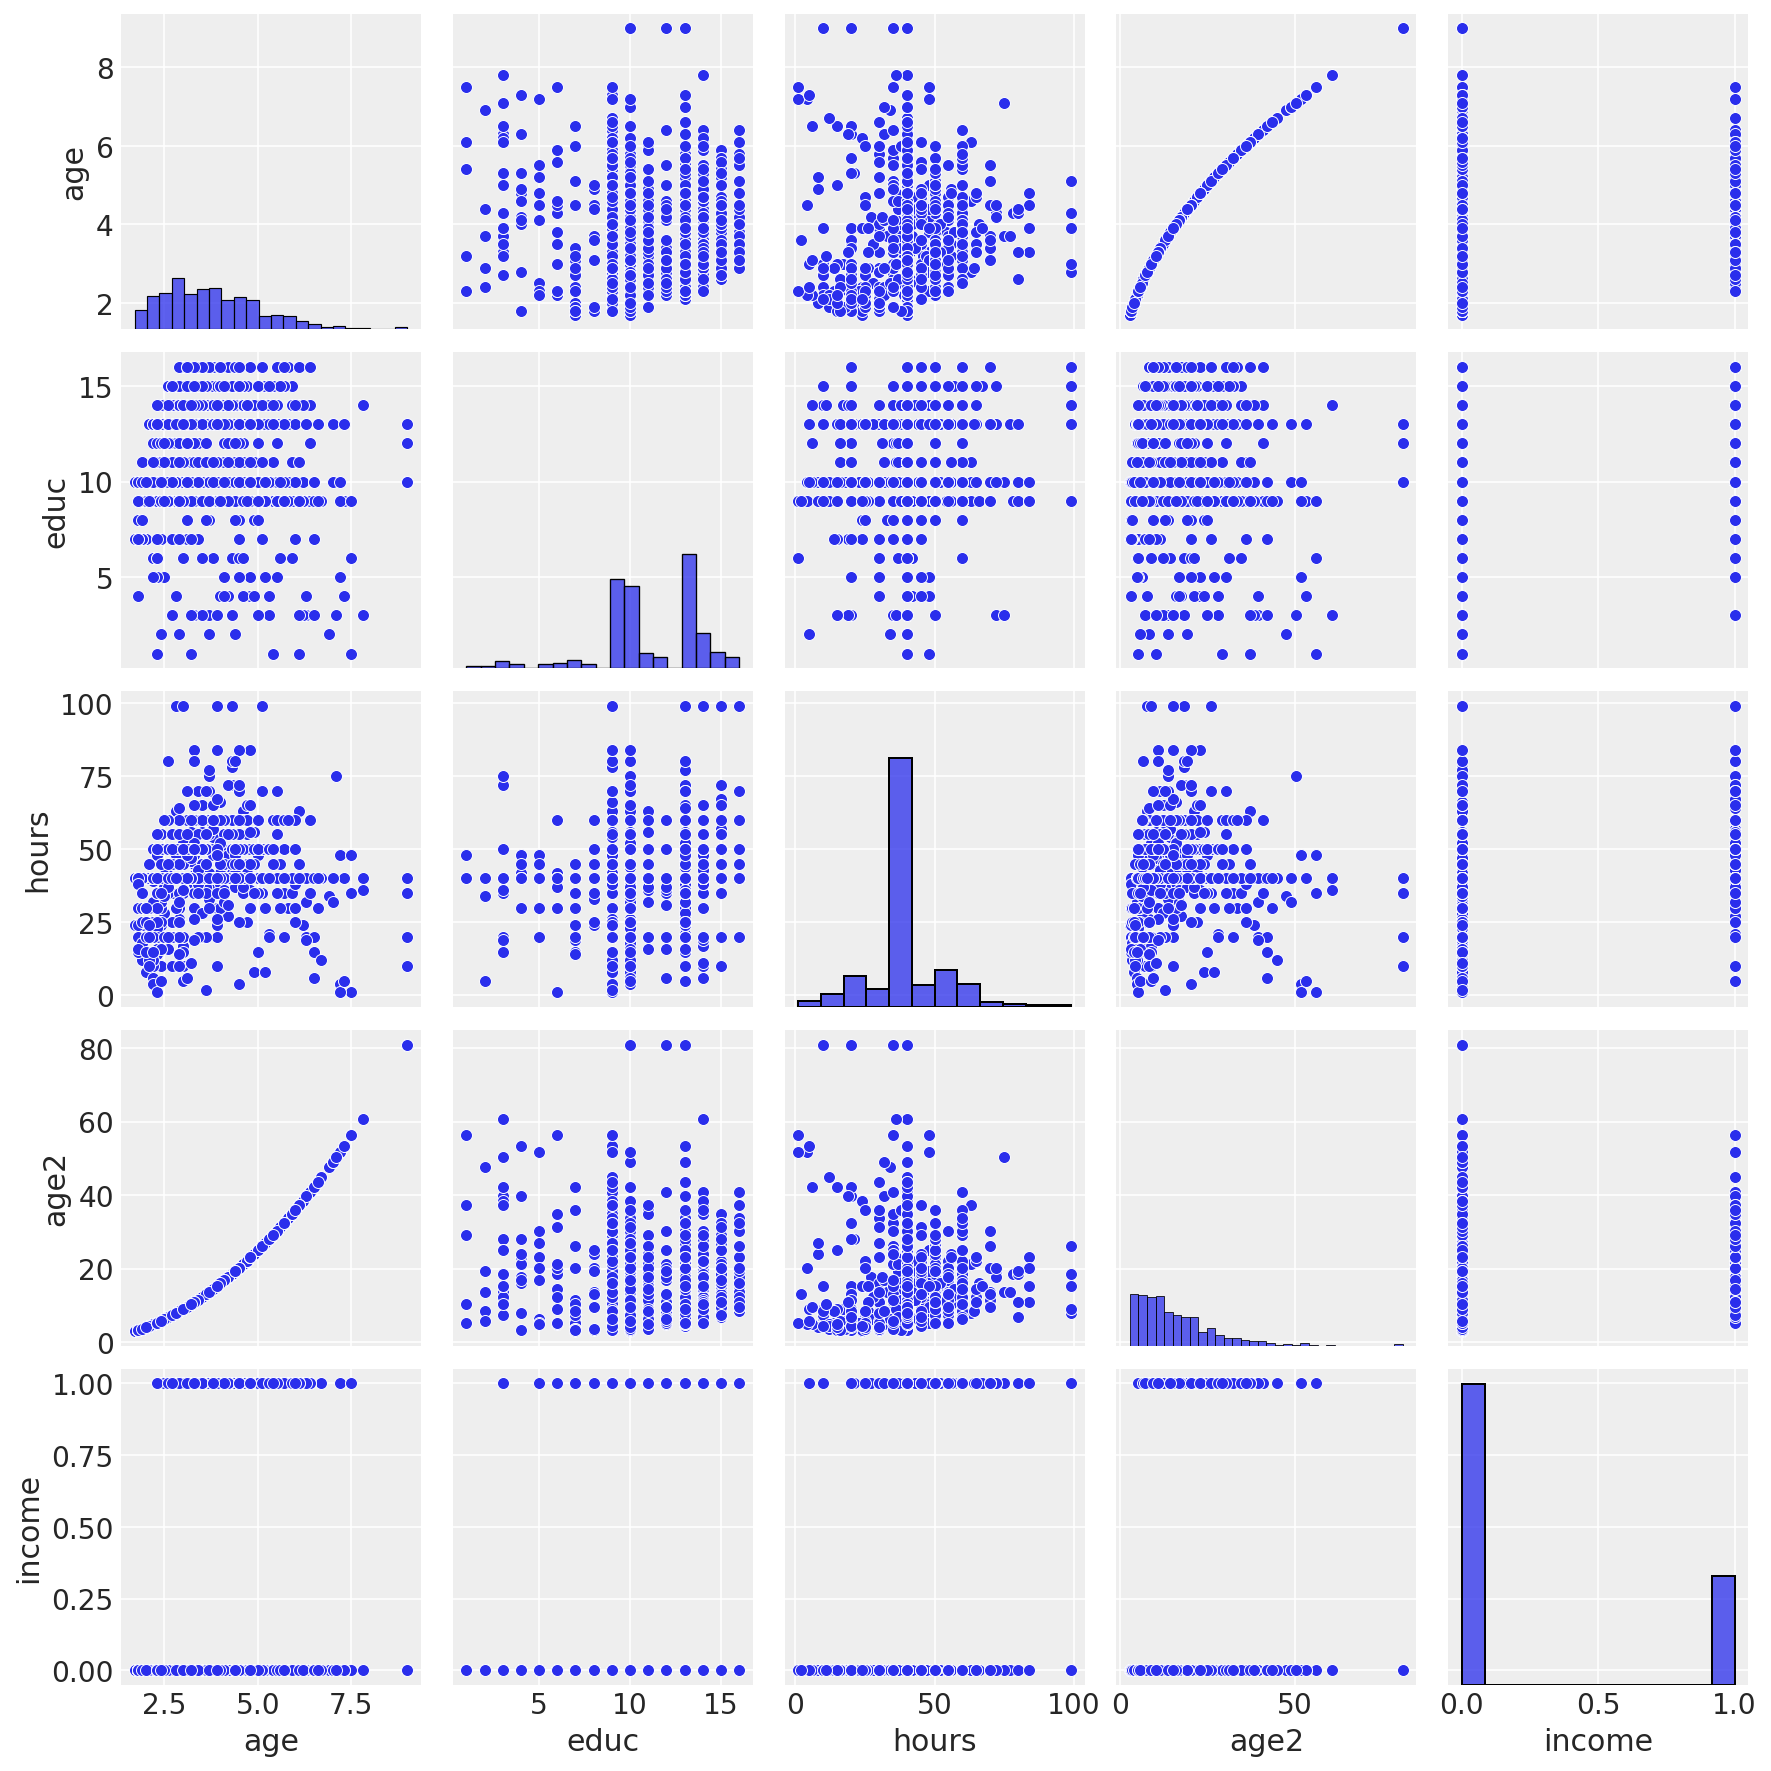

In [ ]:
sns.pairplot(data)

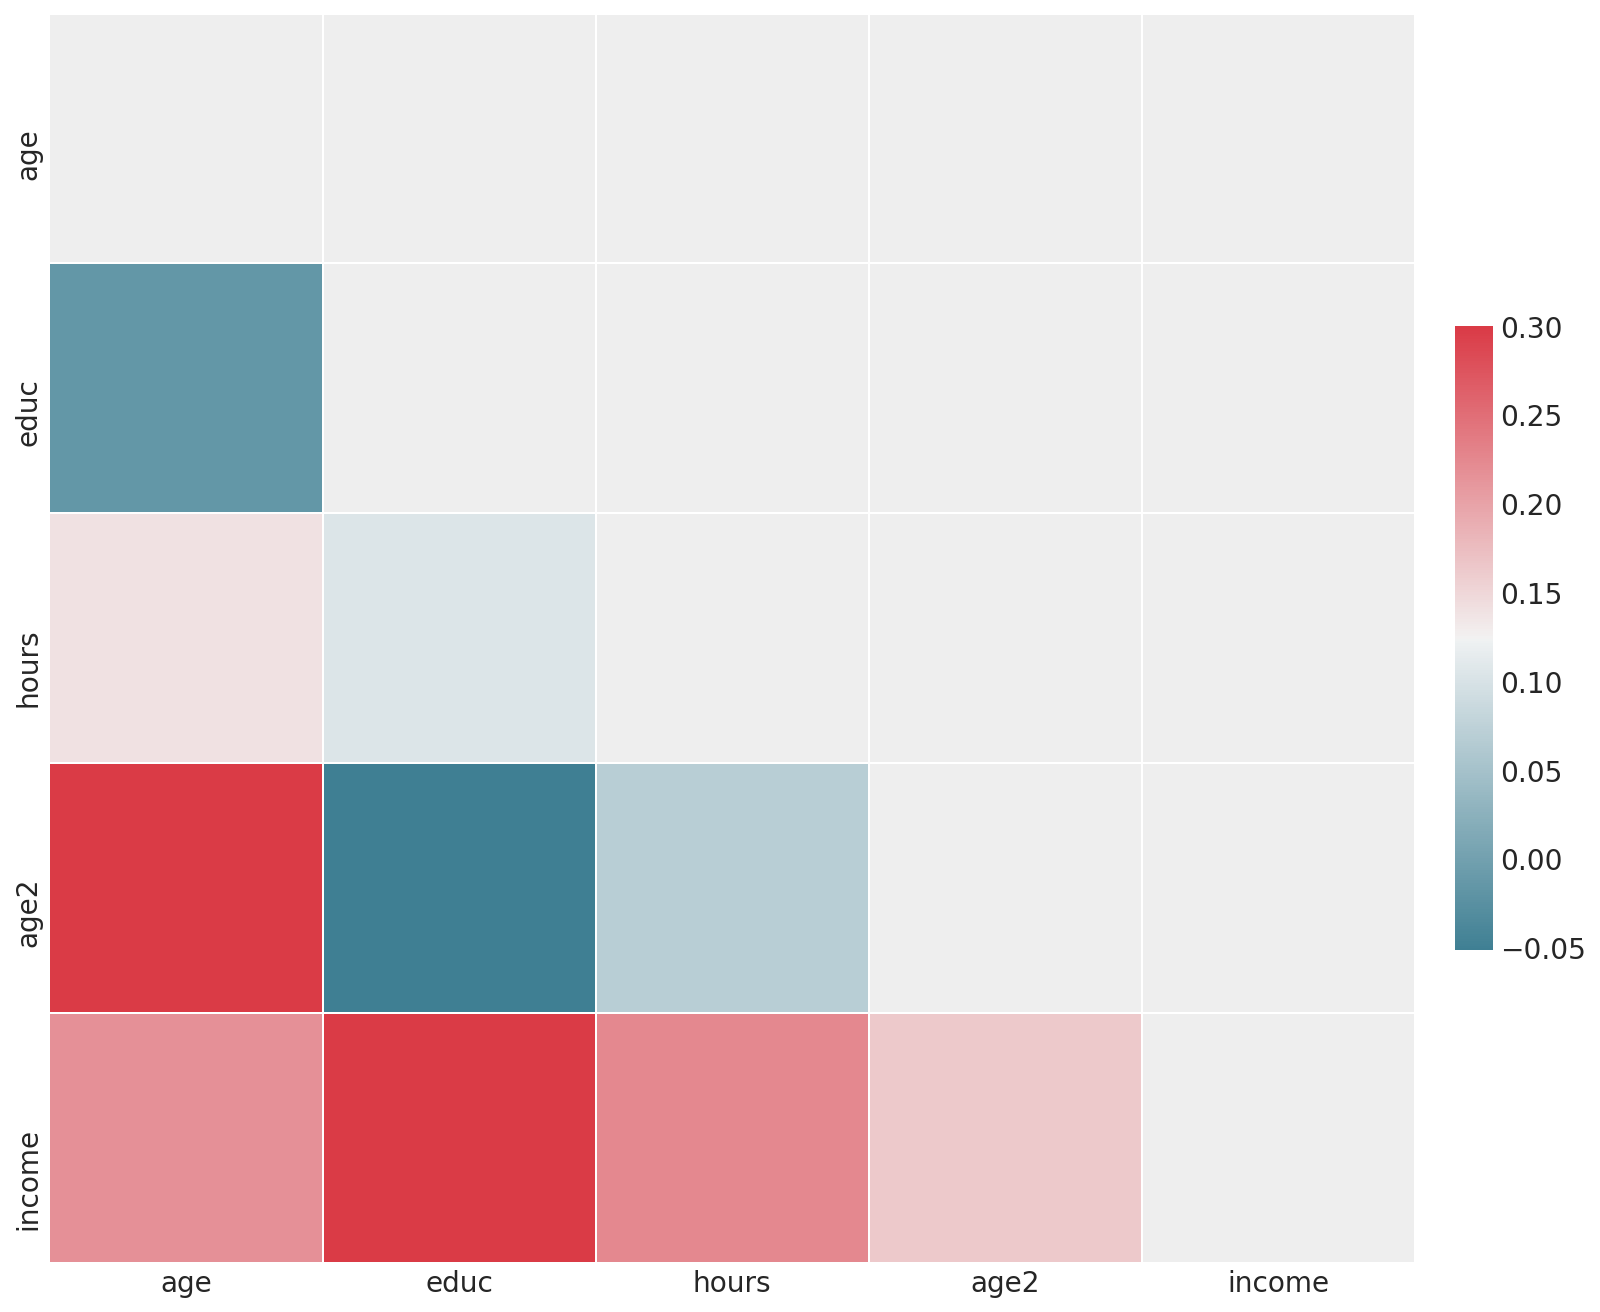

In [ ]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)

## 7.3 モデル
* incomeを目的変数とする。1/0の情報をベルヌーイ分布でモデリング。
* そのベルヌーイ分布のパラメータである1が出る確率を、線形モデルでモデル化。
* 確率なので、リンク関数はlogit関数。
 * logit関数は、ロジスティック関数の逆関数。
 * 線形モデルの出力を、ロジスティック関数に与えて、確率に変換。
* 線形モデルでは、各個人のage, educ, hours特徴量を使用。
 * ただし、上述のように、ageの2乗も説明変数として追加されている。

$$ z_i = \beta_0 + \beta_1 X_{age} + \beta_2 X_{age^2} + \beta_3 X_{educ} + \beta_4 X_{hours} $$
$$ y_i \sim \text{Bernoulli}(p_i) \ , \ p_i = \frac{1}{1 + e^{-z_i}}$$

In [ ]:
with pm.Model() as logistic_model:
  pm.glm.GLM.from_formula(
      "income ~ age + age2 + educ + hours", data, family=pm.glm.families.Binomial()
  )

* sample関数のinit引数は、NUTSサンプラーの初期化方法の指定らしい。
 * https://docs.pymc.io/api/inference.html#module-pymc3.sampling

* （時間がかかります。おそらく30分以上。）

In [ ]:
with logistic_model:
  trace = pm.sample(1000, tune=1000, cores=2, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hours, educ, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.
The number of effective samples is smaller than 25% for some parameters.


## 7.5 事後分布の確認

* サンプルの通常のヒストグラムに平均値を重ねて描くための関数を定義。

In [ ]:
def plot_traces(traces, model, retain=0):
  """
  Convenience function:
  Plot traces with overlaid means and values
  """
  with model:
    ax = az.plot_trace(
        traces[-retain:],
        lines=tuple([(k, {}, v["mean"]) for k, v in pm.summary(traces[-retain:]).iterrows()]),
    )

    for i, mn in enumerate(pm.summary(traces[-retain:])["mean"]):
      ax[i, 0].annotate(
          f"{mn:.2f}",
          xy=(mn, 0),
          xycoords="data",
          xytext=(5, 10),
          textcoords="offset points",
          rotation=90,
          va="bottom",
          fontsize="large",
          color="#AA0022",
      )

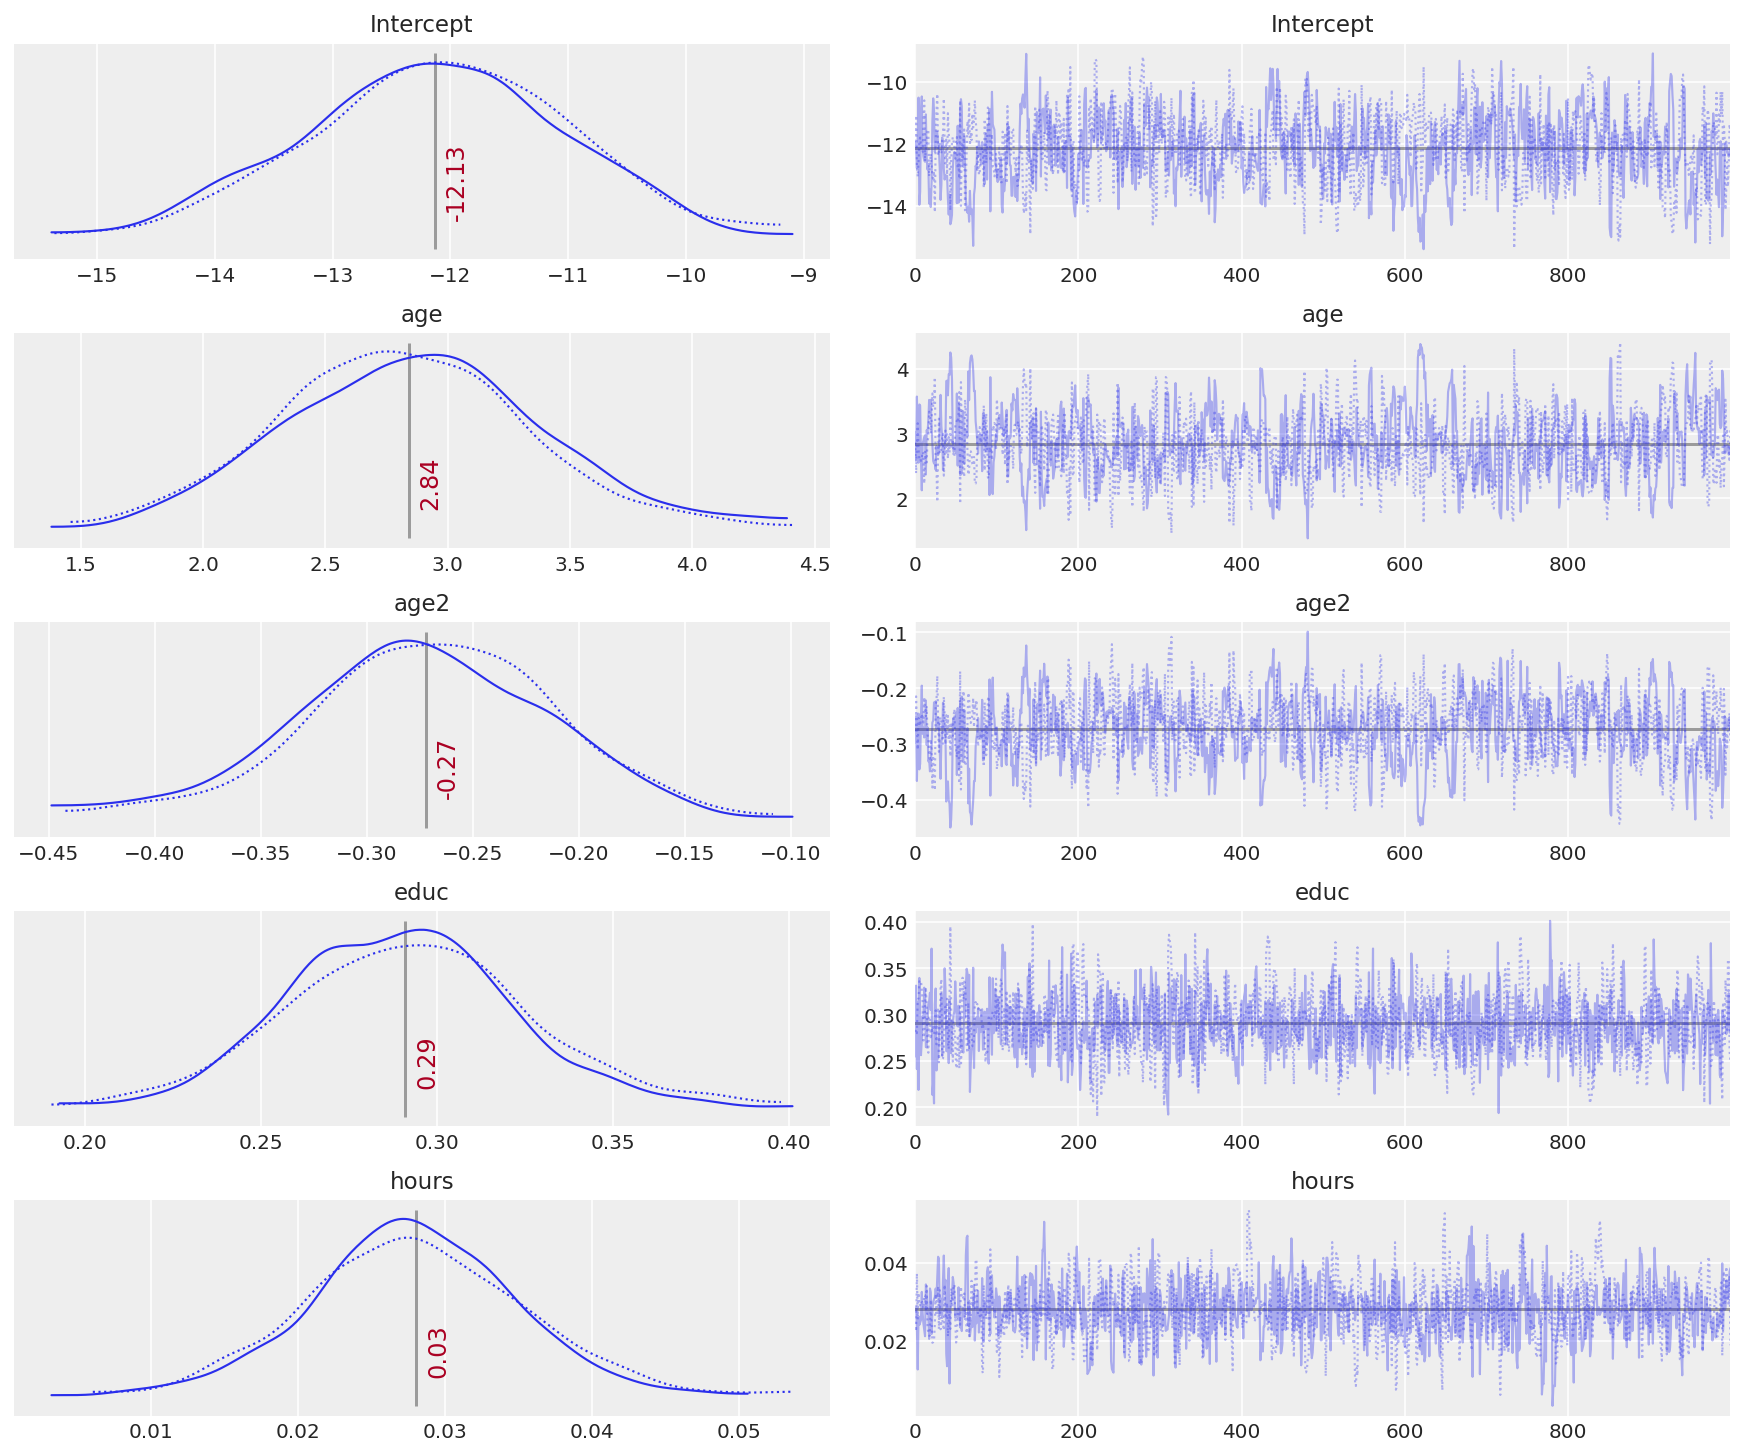

In [ ]:
plot_traces(trace, logistic_model)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


Text(24.375, 0.5, 'beta_educ')

<Figure size 648x504 with 0 Axes>

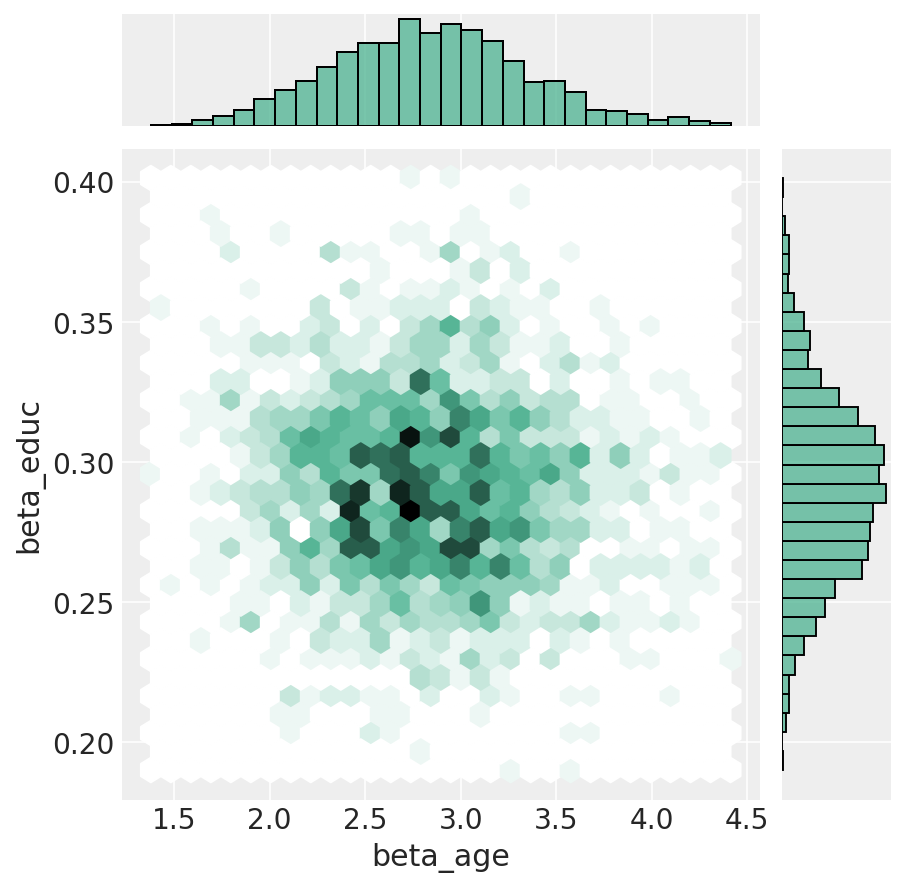

In [ ]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace["age"], trace["educ"], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")

In [ ]:
def lm_full(trace, age, educ, hours):
  shape = np.broadcast(age, educ, hours).shape
  x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age / 10.0, educ, hours]])
  return 1 / (
      1
      + np.exp(
          - (
              trace["Intercept"]
              + trace["age"] * x_norm[0]
              + trace["age2"] * (x_norm[0] ** 2)
              + trace["educ"] * x_norm[1]
              + trace["hours"] * x_norm[2]
            )
      )
  )


# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 12.0, 50.0)

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: lm_full(samples, x, 16.0, 50.0)

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: lm_full(samples, x, 19.0, 50.0)

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


Text(0.5, 0, 'Age')

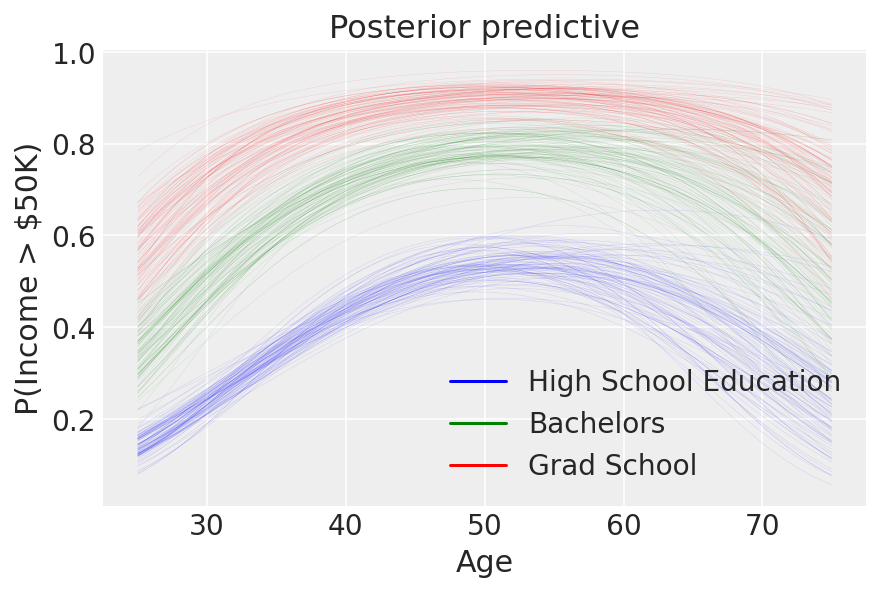

In [ ]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    trace,
    eval=np.linspace(25, 75, 1000),
    lm=lm2,
    samples=100,
    color="green",
    alpha=0.15,
)
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=0.15
)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm"], [], color="b", label="High School Education")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Bachelors")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Grad School")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")

In [ ]:
trace['educ']

array([0.25514905, 0.3314539 , 0.24142688, ..., 0.35933949, 0.26100347,
       0.24942143])

* ロジットの差はオッズ比の対数に当たる。
$$\log\Big(\frac{p}{1-p}\Big) - \log\Big(\frac{p^\prime}{1-p^\prime}\Big) = \log \frac{ p / (1-p) }{ p^\prime / (1 - p^\prime) }$$
* よって、GLMでリンク関数がlogit関数のとき、線形モデルの係数のexponentialは、オッズ比の差分の意味を持つ。
 * その係数に対応する説明変数の値が1増えると、線形モデルの出力が係数分だけ増える。
 * つまり、オッズ比の対数が、係数分だけ増える。

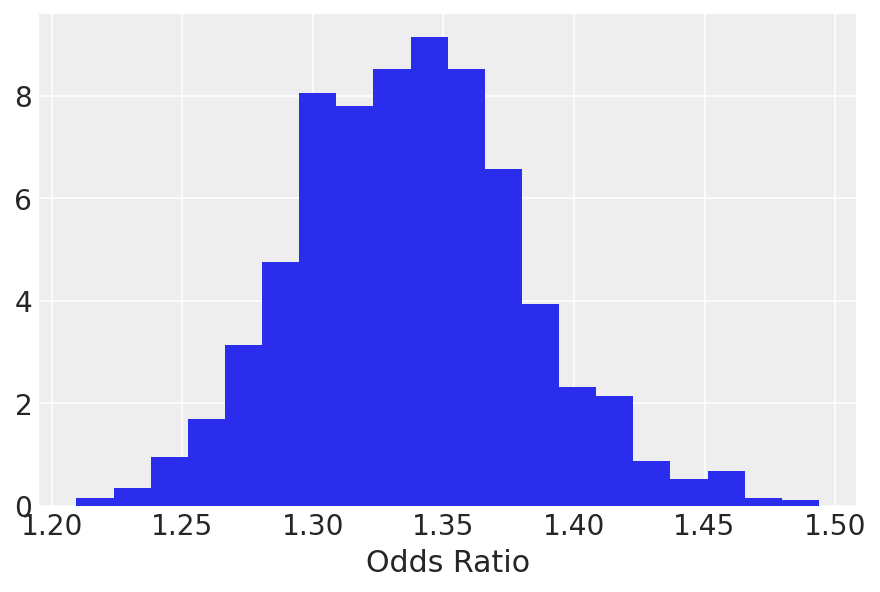

In [ ]:
b = trace["educ"]
plt.hist(np.exp(b), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.show()

In [ ]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.255 < O.R. < 1.431) = 0.95


# 課題
* PyMC3を使って、何かデータ分析をおこなってみてください。
 * データは何でもいいです。
 * 「ここにあったこの分析を再現してみました」的なコードでもいいです。